In [90]:
# Please execute this cell (shift+<Return>) before starting the workbook
# this should print out "Your notebook is ready to go"
from IPython.display import HTML, SVG, display
import genealogical_analysis_workshop

workshop = genealogical_analysis_workshop.setup()
display(HTML(workshop.css))
print("Your notebook is ready to go")

Your notebook is ready to go


# Simulating ancestry with msprime

We will use `msprime`, a backwards-time tree sequence simulator, to generate genealogical trees with mutations occurring along them. We will simulate genomic data sets using two demographic models: (1) a simple model with a single, panmictic population and (2) a stepping stone model with six populations. `msprime ` can simulate data under more complicated demographic models, but it is not demonstrated in this workshop (see the end of this notebook for links and tutorials).
 
### Why do we do simulations in population genetics?

**Exploration:**
Simulations allow us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance.

**Benchmarking and evaluating methodologies:**
To assess the accuracy of inferential methods, we need test datasets for which the true values of important parameters are known.

**Model training:**
Some methods for ancestry inference are trained on simulated data (e.g., Approximate Bayesian Computation).
This is especially important in studies of complex demographies, where there are many potential parameters and models, making it impractical to specify likelihood functions.

### A brief history of msprime

The first release of `msprime` was an emulation of the popular `ms` coalescent simulator with added support for tree sequences.
However, it has since become an expansive and flexible backwards-in-time simulator for various different models of genetic ancestry and mutation, and even for simplified models of selection.
There is a *forwards-time* simulator named `SLiM` which is not covered in this workshop.
Furthermore, it is possible to combine *backwards-time* and *forwards-time* simulations from `msprime` and `SLiM`.

### Backwards simulation

The main characteristic of `msprime` is that is simulates *tree sequences* in *backwards-time*.

<img src="pics/msprime-1.png" width="200" height="200">
<img src="pics/msprime-2.png" width="200" height="200">
<img src="pics/msprime-3.png" width="200" height="200">
<img src="pics/msprime-4.png" width="200" height="200">
<img src="pics/msprime-5.png" width="200" height="200">

In [73]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

import msprime
import tskit
import tsinfer
import tsdate
import demesdraw

## Basic syntax to simulate a tree sequence

To perform simulations using `msprime`, we first simulate a tree sequence without mutations (i.e. the genetic genealogy) using `sim_ancestry()`. If desired, we then add neutral mutations to the tree sequence using `sim_mutations()`.

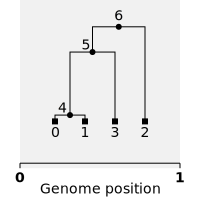

In [76]:
ts = msprime.sim_ancestry(
    samples=2, # two diploid individuals
    random_seed=1
)
SVG(ts.draw_svg())

In [77]:
ts # note there are no mutations yet

## Specifying information about sample genomes
Although we have specified 2 samples, our tree sequence contains 4 sample nodes (i.e. sample genomes).
This is because the `samples` argument specifies the number of *individuals* in the sample,
and by default, `sim_ancestry()` assumes diploid organisms.
To change this, use the `ploidy` argument:

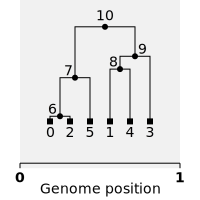

In [78]:
ts = msprime.sim_ancestry(
    samples=2,
    ploidy=3, # two triploid individuals
    random_seed=1
)
SVG(ts.draw_svg())

It's easiest to start thinking about genome lengths in units of nucleotides. By default, we are simulating a sequence length that spans just one of these units.
We can specify a larger region using the `sequence_length` argument:

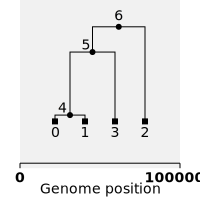

In [80]:
ts = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e6, # 10 bp long
    random_seed=1
)
SVG(ts.draw_svg())

Also, note that our 'tree sequence' consists of just a single tree. This is because we have not yet specified a `recombination_rate`, which is set to 0 by default. 
This is the probability of a recombination event per genomic unit (base), per generation.

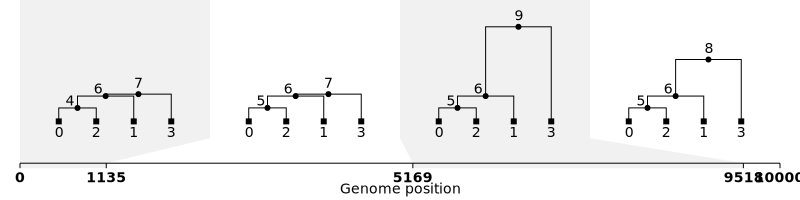

In [89]:
ts = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e4,
    recombination_rate=1e-4, # allow for recombination
    random_seed=100
)
SVG(ts.draw_svg())

<dl><dt>Exercise 1</dt><dd>Simulate a tree sequence with 20 diploid individuals, each with a 1 Mbp long genome, using a recombination rate of 1e-8. Run the simulation with a random seed of 2022.</dd></dl>

<dl><dt>Question 1</dt><dd>How many trees are in the tree sequence?</dd></dl>

## Basic syntax to simulation mutations along the tree sequence

Next, to simulate mutations, we apply `sim_mutations()` on an existing `TreeSequence` object.
At minimum, you must supply a per-base, per-generation mutation rate.

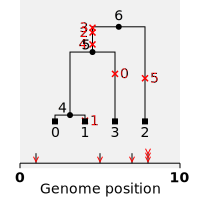

In [10]:
mts = msprime.sim_mutations(
    ts, # generated from the step above
    rate=0.10, # mutation rate
    random_seed=2
)
SVG(mts.draw_svg())

In [13]:
mts # note there are five sites with variation and six mutations

In [16]:
mts.tables.sites

id,position,ancestral_state,metadata
0,1.00000000,T,b''
1,5.00000000,T,b''
2,7.00000000,C,b''
3,8.00000000,C,b''


In [17]:
mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,3,1.35540758,G,-1,b''
1,1,1,0.02039417,A,-1,b''
2,2,5,2.53476625,A,-1,b''
3,3,5,2.67062444,G,-1,b''
4,3,5,2.19468609,C,3,b''
5,3,2,1.23007336,A,-1,b''


Notice that some sites have experienced multiple mutations.
To view the sequence information at each successive site, we can use the `variants()` method, which iterates over a ``TreeSequence`` object:

In [21]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

0.0	('C', 'G')	[0 0 0 1]
1.0	('T', 'G')	[1 1 1 0]
2.0	('A', 'C')	[1 0 0 0]
3.0	('G', 'T')	[0 1 1 0]
7.0	('T', 'A')	[0 0 0 0]


<dl><dt>Exercise 2</dt><dd>Simulate some mutations along the tree sequence generated in Exercise 1 using a mutation rate of 1e-8. Run the simulation using a random seed of 2022.</dd></dl>

<dl><dt>Question 2</dt><dd>How many sites with variation are in the tree sequence?</dd></dl>

## More complicated simulations
 - **Recombination rate variation across the genome** We can introduce this by creating a `RateMap` object, which lists recombination rates between defined positions in the sequence.
```
recomb_rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=recomb_rate_map, random_seed=2)
SVG(ts.draw_svg())
```
 - **Mutation rate variation across the genome** This can also be introduced using a `RateMap` object, which lists mutation rates between defined position in the sequence.
```
mutation_rate_map = msprime.RateMap(position=[0, 40, 60, 100], rate=[0.01, 0.1, 0.01])
mts = msprime.sim_mutations(ts, rate=mutation_rate_map, random_seed=104)
SVG(mts.draw_svg())
```
 - **Mutation models** There are pre-defined models (e.g., Jukes-Cantor). You can also use your own custom models.
 - **Stacking mutations** Mutations can be simulated on the same tree sequence under different models and/or parameters and/or over different time periods.
 - **Continuous coordinates** By default, the recombination and mutation events will be assigned to integer locations along the sequence. However, there may be situations where you want to model the genome using continuous coordinates. In this case, use the `discrete_genome=False` argument:
```
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=28,
    sequence_length=100,
    recombination_rate=0.01,
    discrete_genome=False
)
SVG(ts.draw_svg())
```
 - **Gene conversion** See the API documentation for the `gene_conversion_rate` and `gene_conversion_tract_length` arguments, and [this](https://tskit.dev/msprime/docs/stable/ancestry.html?highlight=gene%20conversion#gene-conversion) short tutorial.

## Simulations under custom demographic models

To simulate under more complicated models of demographic history, we need to create a `msprime.Demography` object.

`msprime` supports simulation from multiple discrete populations, each of which is initialized via the `add_population()` method.
For each population, you can specify a sample size, an effective population size, an exponential growth rate and a name.

Let's simulate some data using a stepping stone model with six populations.

In [68]:
deme_size = 1_000 # population size of each deme
num_demes = 6
num_deme_samples = 5

In [91]:
demography = msprime.Demography.stepping_stone_model(
    [deme_size] * num_demes,
    migration_rate=0.01
)

We can visualise demographic models using `demesdraw`.

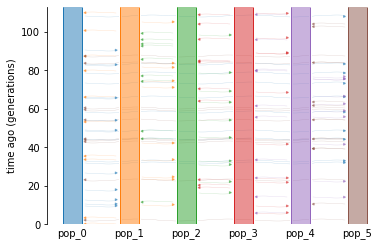

In [92]:
graph = msprime.Demography.to_demes(demography) # for visualization only

positions = {f"pop_{i}": i*deme_size*3 for i in range(num_demes)}

fig, ax = plt.subplots() # use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph,
                ax=ax,
                positions=positions,
                seed=3)
plt.show()

In [93]:
ts = msprime.sim_ancestry(
    {i: num_deme_samples for i in range(num_demes)},
    sequence_length=1e6, # 1 Mbp
    demography=demography,
    recombination_rate=1e-8, # human-like recombination rate
    random_seed=3,
)

ts = msprime.sim_mutations(
    ts,
    rate=1e-8, # human-like mutation rate
    random_seed=3
)

Let's check the Fst statistics between the populations.

In [96]:
Fst_01 = ts.Fst(
    [
        ts.samples(0), # pop_0
        ts.samples(1)  # pop_1
    ],
    mode="branch"
)

Fst_05 = ts.Fst(
    [
        ts.samples(0), # pop_0
        ts.samples(5)  # pop_5
    ],
    mode="branch"
)

print(f"Fst between pop_0 and pop_1 = {Fst_01}")
print(f"Fst between pop_0 and pop_5 = {Fst_05}")

Fst between pop_0 and pop_1 = 0.02114871196191126
Fst between pop_0 and pop_5 = 0.008156542648851905


<dl><dt>Exercise 3</dt><dd>Get the Fst between population 0 and all the other populations.</dd></dl>

<dl><dt>Question 3</dt><dd>What is the Fst between population 0 and population 3?</dd></dl>

In [97]:
sample_data = tsinfer.SampleData.from_tree_sequence(ts)

inferred_ts = tsinfer.infer(sample_data)

dated_ts = tsdate.date(
    tsdate.preprocess_ts(inferred_ts),
    mutation_rate=1e-8,
    Ne=6_000,
    ignore_oldest_root=True
)

Note that branch-wise statistics differ noticeably between the *simulated* tree sequence and the *inferred* and *dated* tree sequences. This is because the branch lengths in the tree sequence derived straight from `tsinfer` are not meaningful. Branch lengths need to be estimated using `tsdate`.

In [106]:
# Perform site-wise calculations.
Fst_true_ts = ts.Fst([ts.samples(0), ts.samples(5)])
Fst_inferred_ts = inferred_ts.Fst([inferred_ts.samples(0), inferred_ts.samples(5)]) # topology only
Fst_dated_ts = dated_ts.Fst([dated_ts.samples(0), dated_ts.samples(5)])

# Perform branch-wise calculations.
Fst_branch_true_ts = ts.Fst([ts.samples(0), ts.samples(5)], mode="branch")
Fst_branch_inferred_ts = inferred_ts.Fst([inferred_ts.samples(0), inferred_ts.samples(5)], mode="branch")
Fst_branch_dated_ts = dated_ts.Fst([dated_ts.samples(0), dated_ts.samples(5)], mode="branch")

print(
    "Site-wise calculations:",
    f"Fst (true     ts) = {Fst_true_ts}",
    f"Fst (inferred ts) = {Fst_inferred_ts}",
    f"Fst (dated    ts) = {Fst_dated_ts}",
    sep="\n",
)

print("\n")

print(
    "Branch-wise calculations:",
    f"Fst (true     ts) = {Fst_branch_true_ts}",
    f"Fst (inferred ts) = {Fst_branch_inferred_ts}",
    f"Fst (dated    ts) = {Fst_branch_dated_ts}",
    sep="\n",
)

Site-wise calculations:
Fst (true     ts) = 0.009670850912044893
Fst (inferred ts) = 0.009670850912044893
Fst (dated    ts) = 0.009670850912044893


Branch-wise calculations:
Fst (true     ts) = 0.008156542648851905
Fst (inferred ts) = 0.00913075261642271
Fst (dated    ts) = 0.01274765556388735


In [107]:
# Perform site-wise calculations.
div_true_ts = ts.divergence([ts.samples(0), ts.samples(5)])
div_inferred_ts = inferred_ts.divergence([inferred_ts.samples(0), inferred_ts.samples(5)])
div_dated_ts = dated_ts.divergence([dated_ts.samples(0), dated_ts.samples(5)])

# Perform branch-wise calculations.
div_branch_true_ts = ts.divergence([ts.samples(0), ts.samples(5)], mode="branch")
div_branch_inferred_ts = inferred_ts.divergence([inferred_ts.samples(0), inferred_ts.samples(5)], mode="branch")
div_branch_dated_ts = dated_ts.divergence([dated_ts.samples(0), dated_ts.samples(5)], mode="branch")

print(
    "Site-wise calculations:",
    f"divergence (true     ts) = {div_true_ts}",
    f"divergence (inferred ts) = {div_inferred_ts}",
    f"divergence (dated    ts) = {div_dated_ts}",
    sep="\n",
)

print("\n")

print(
    "Branch-wise calculations:",
    f"divergence (true     ts) = {div_branch_true_ts}",
    f"divergence (inferred ts) = {div_branch_inferred_ts}",
    f"divergence (dated    ts) = {div_branch_dated_ts}",
    sep="\n",
)

Site-wise calculations:
divergence (true     ts) = 0.00023745999999999856
divergence (inferred ts) = 0.00023745999999999856
divergence (dated    ts) = 0.00023745999999999856


Branch-wise calculations:
divergence (true     ts) = 21979.377248386285
divergence (inferred ts) = 1.2686422366024814
divergence (dated    ts) = 24939.10971290058


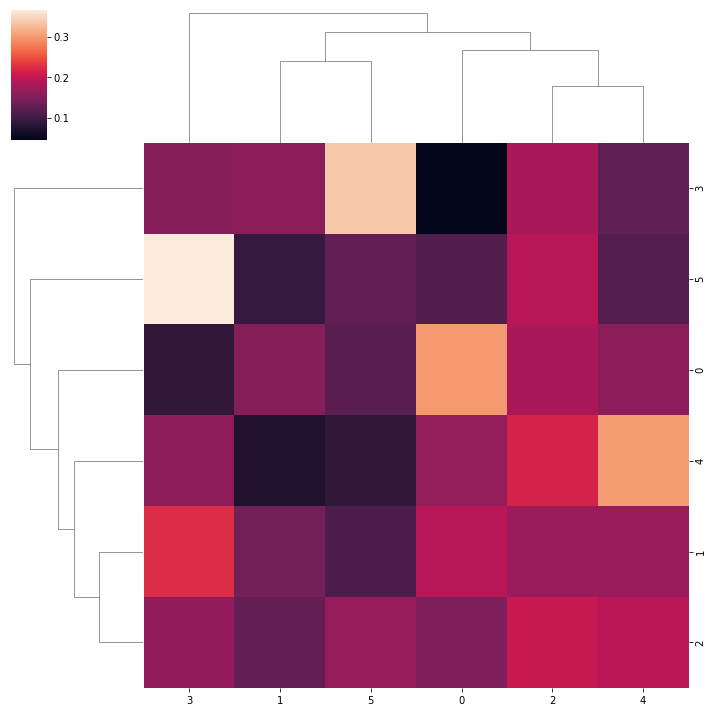

In [102]:
gnn_heatmap = np.array([
    np.mean(
        ts.genealogical_nearest_neighbours(
            ts.samples(i),
            [ts.samples(j) for j in range(num_demes)]),
        axis=0,
    )
    for i in range(num_demes)
])

sns.clustermap(gnn_heatmap);

## Running the same simulation many times

Variation among simulated genetic genealogies means that there is variation in branch-wise statistics among the genealogies as well. To see this, we need a bunch of simuation replicates. The `num_replicates` argument in `sim_ancestry()` offers a convenient way to run many simulations under the same model.

In [ ]:
Fst_values = []

for ts in msprime.sim_ancestry(
    {i: num_deme_samples for i in range(num_demes)},
    sequence_length=1e6,
    demography=demography,
    recombination_rate=1e-8,
    random_seed=1234,
    num_replicates=100
):
    Fst = ts.Fst([ts.samples(0), ts.samples(5)], mode="branch")
    Fst_values.append(Fst)

<dl><dt>Question 4</dt><dd>What is the mean Fst across the simulated genetic genealogies?</dd></dl>

## More complicated demographic models
 - Varying population size.
 - Population structure (multiple demes with different migration rates).
 - Migration (constant or varying migration rates).
 - Admixture.
 - Population divergence.

## Other topics of interest
 - Forward simulations using `SLiM` (and recapitation).
 - Community-validated demographic models (`stdpopsim`).
 - Combining demographic models.
 - Simple selective sweeps.
 - Debugging demographic models.
 
## Some relevant papers and resources
 -  [Efficient coalescent simulation and genealogical analysis for large sample sizes](https://doi.org/10.1371/journal.pcbi.1004842)
 - [Efficient ancestry and mutation simulation with msprime 1.0](https://doi.org/10.1093/genetics/iyab229)
 - [tskit.dev documentation](https://tskit.dev/)
 - [Georgia Tsambos' Jupyter notebooks](https://github.com/gtsambos/2022-ts-workshops)